# Matrix Factorisation - Linear

This is the classical collaborative filtering model


In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item_withencoder, random_split, user_split, remove_year

In [3]:
%matplotlib inline

### Prepare the data

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Apply the function to the 'title' column
df_items['cleaned_title'] = df_items['title'].apply(remove_year)

# Display the updated DataFrame
#print(df_items[['movie_id', 'title', 'cleaned_title']].head())

In [6]:
df_items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count,cleaned_title
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,1995.0,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,10878.0,Toy Story
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,1,0,0,1995.0,James Bond must unmask the mysterious head of ...,en,130.0,6.8,2037.0,GoldenEye
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,1,0,0,1995.0,It's Ted the Bellhop's first night on the job....,en,98.0,6.1,1251.0,Four Rooms
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,1995.0,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,501.0,Get Shorty
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,1,0,0,1995.0,An agoraphobic psychologist and a female detec...,en,124.0,6.5,424.0,Copycat


In [7]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item_withencoder(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [8]:
DATA.head()

,USER,ITEM,RATING,TIMESTAMP
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


In [9]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [10]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [11]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = random_split(DATA, [0.8, 0.2])

In [12]:
train.shape, test.shape

((80000, 5), (20000, 5))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product

In [13]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils import plot_model
from keras.utils import model_to_dot
#from reco import vis

### Build the Model

In [14]:
def ExplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [15]:
n_factors = 40
model = ExplicitMF(n_users, n_items, n_factors)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Item (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ User (InputLayer)             │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ItemEmbedding (Embedding)     │ (None, 1, 40)             │          67,280 │ Item[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ UserEmbedding (Embedding)     │ (None, 1, 40)             │          37,720 │ User[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenItemsE (Flatten)       │ (None, 40)                │               0 │ ItemEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ FlattenUsersE (Flatten)       │ (None, 40)                │               0 │ UserEmbedding[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ DotProduct (Dot)              │ (None, 1)                 │               0 │ FlattenItemsE[0][0],       │
│                               │                           │                 │ FlattenUsersE[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 105,000 (410.16 KB)

 Trainable params: 105,000 (410.16 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from reco.recoutils import create_directory
create_directory("/model-img")

Directory already exists C:\Users\sadha\OneDrive\Desktop\Movie Recommendation System/model-img


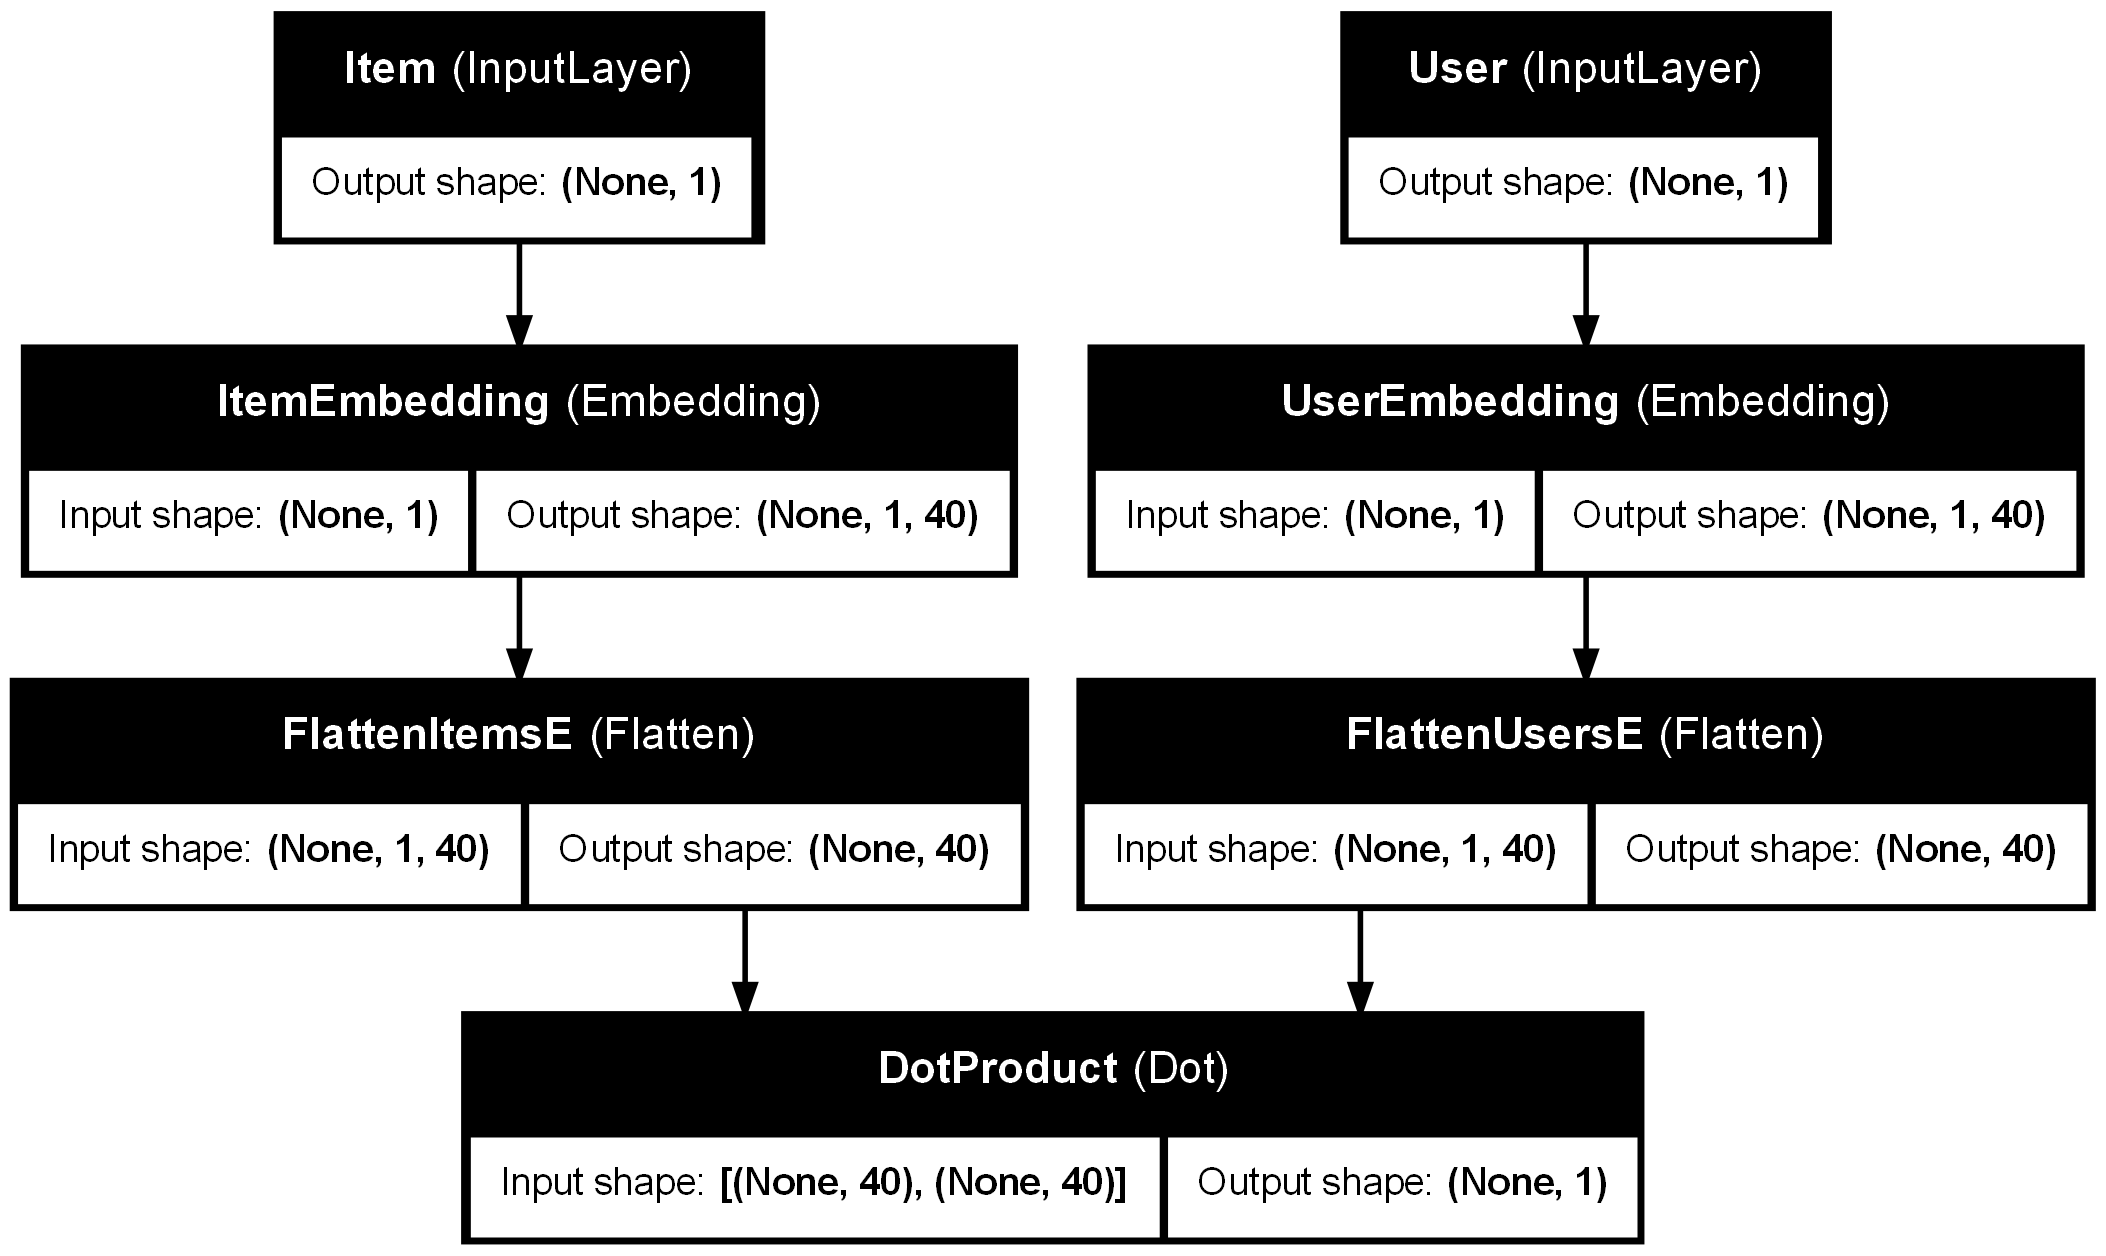

In [18]:
plot_model(model, show_layer_names=True, show_shapes=True, to_file="model-img/explicit-mf.png" )

### Train the Model

In [19]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 13.5589 - val_loss: 9.9999
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.5867 - val_loss: 3.3927
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4419 - val_loss: 2.5213
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0547 - val_loss: 2.2398
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9283 - val_loss: 2.1050
Wall time: 14.7 s


In [20]:
#vis.metrics(output.history)

### Score the Model

In [21]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3340


2.6343183517456055

### Evaluate the Model

In [22]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [23]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [24]:
%%time
predictions = get_predictions(model, DATA)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 74s 1ms/step
Wall time: 2min 16s


In [25]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,4.240520
1,195,301,4.079826
2,195,376,1.738630
3,195,50,3.421854
4,195,345,3.939711


In [26]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

49567/49567 ━━━━━━━━━━━━━━━━━━━━ 67s 1ms/step
Wall time: 2min 31s


In [27]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.057453
Precision@K:	0.041316
Recall@K:	0.029873


### Get Similar Items

In [28]:
from reco.recommend import get_similar, show_similar

In [29]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

Wall time: 130 ms


In [30]:
item_similar_indices

array([[   0,  297, 1015,  590,  256],
       [   1,   76,  218,  225,  558],
       [   2,  715,  266,   89,   26],
       ...,
       [1679, 1664, 1674, 1672, 1629],
       [1680, 1610, 1681, 1658, 1365],
       [1681, 1610, 1626, 1351, 1664]], dtype=int64)

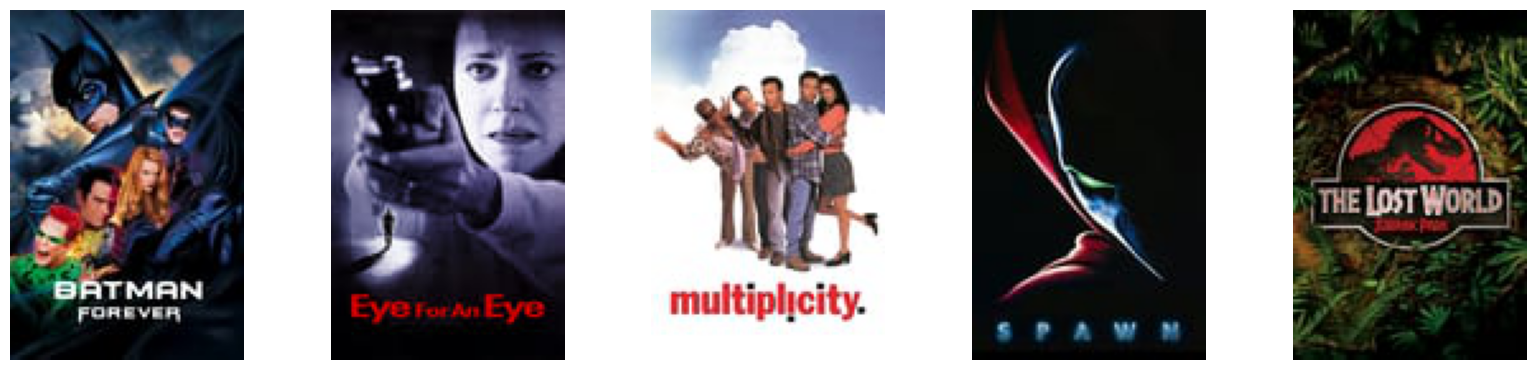

In [31]:
show_similar("Apollo 13", item_similar_indices, item_encoder, df_items)